In [62]:
!ls -l -h records/ugo/2022-02

total 1.9G
-rw-rw-r-- 1 user user 916M Aug 20 15:06 2019.jsonl
-rw-rw-r-- 1 user user 634M Aug 20 14:58 2020.jsonl
-rw-rw-r-- 1 user user 369M Aug 20 14:48 2021.jsonl


In [63]:
!ls -l -h records/ugo/2022-08

total 4.8G
-rw-rw-r-- 1 user user 942M Aug 20 14:42 2016.jsonl
-rw-rw-r-- 1 user user 923M Aug 20 15:02 2017.jsonl
-rw-rw-r-- 1 user user 891M Aug 20 15:17 2018.jsonl
-rw-rw-r-- 1 user user 856M Aug 20 14:46 2019.jsonl
-rw-rw-r-- 1 user user 649M Aug 20 14:51 2020.jsonl
-rw-rw-r-- 1 user user 550M Aug 20 14:54 2021.jsonl
-rw-rw-r-- 1 user user  39M Aug 20 14:51 2022.jsonl


In [64]:
!ls -l -h records/ugo/2023-03

total 1.2G
-rw-rw-r-- 1 user user 704M Aug 20 15:13 2021.jsonl
-rw-rw-r-- 1 user user 478M Aug 20 15:09 2022.jsonl


In [ ]:
blacklist = {
    'case_user_document_num',
    'case_document_id',
    'case_id',
    'case_id_region',
    'case_common_document_num',
    'case_common_doc_number',
    'case_common_event_m2',
    'case_user_document_text_tag',
    'u_common_case_defendant_m',
    'case_regbasenum',
    'case_common_parts_m2_search',
    'case_common_doc_validity_date',
    'case_doc_load_date',
    'case_document_load_date',
    'case_document_num_build',
    'case_document_publ_date',
    'case_document_result_date',
    'timestamp',
    'case_year',
    'case_year_entry',
    'case_year_result',
    'case_common_document_type',
    'case_document_result'
}

In [34]:
from collections import defaultdict, Counter
import lzma
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

files = {f'ugo/{d}/{y}' for d, r in {'2022-02':range(2019, 2022), '2022-08':range(2016, 2023), '2023-03':range(2021, 2023)}.items() for y in r}
records = {f'records/{f}.jsonl' for f in files}
keys = {
    'id',
    'case_common_doc_court',
    'case_common_doc_entry_date',
    'case_common_doc_result',
    'case_common_doc_result_date',
    'case_common_judge',
    'case_court_type',
    'case_doc_district_rf',
    'case_doc_instance',
    'case_doc_subject_rf_code',
    'case_document_articles',
    'case_common_type',
    'case_user_doc_validity_date',
    'txt_exist'
}

In [13]:
def process_record(record):
    precord = {key: '-' for key in keys}
    for key, value in record.items():
        if key in keys:
            if key.endswith('date'):
                precord[key] = value[:10]
            elif key == 'case_document_articles':
                precord[key] = [el.replace('[', '').strip() for el in value
                                for el in el.split(';')
                                for el in el.split(']')
                                for el in el.split('-')]
            else:
                precord[key] = value
    return precord

def add_to_jsonl(records, wpath):
    with open(wpath, 'a') as file:
        file.write('\n'.join(json.dumps(rec) for rec in records) + '\n')

def process_file(r_file, w_file):
    with lzma.open(r_file, mode='rt', encoding='utf-8') as file:
        precords = []
        chunk_size = 0
        for line in file:
            record = json.loads(line)
            precord = process_record(record)
            precords.append(precord)
            chunk_size += 1
            if chunk_size >= 1000:
                add_to_jsonl(precords, w_file)
                precords = []
                chunk_size = 0
        add_to_jsonl(precords, w_file)

In [60]:
for f in files:
    process_file(f'/mnt/frodus/{f}.unique.jsonl.xz', f'records/{f}.jsonl')

In [25]:
def prepare_data(records, filters=None, filters_b=None):
    if filters is None:
        filters = {}
    if filters_b is None:
        filters_b = {}

    stats = defaultdict(Counter)
    
    for rpath in records:
        d, y = f'{rpath[12:19]}', f'{rpath[20:24]}'
        with open(rpath, 'r') as file:
            for line in file:
                rec = json.loads(line)
                
                if any(v not in rec.get(k, '') for k, v in filters.items()):
                    continue
                
                if any(v in rec.get(k, '') for k, v in filters_b.items()):
                    continue

                stats[d][y] += 1
    
    return stats

In [30]:
filters = {'case_doc_district_rf':'Приволжский федеральный округ', 'case_common_doc_result':'Вынесен ПРИГОВОР'}
filters_block = {'case_common_judge':'-', 'case_common_type':'-'}

data = prepare_data(records)

In [43]:
def plot_stats(data):
    years = sorted(set(year for counter in data.values() for year in counter))
    labels = list(data.keys())
    
    num_dates = len(labels)
    width = 0.8 / num_dates
    x = np.arange(len(years))
    
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, label in enumerate(labels):
        heights = [data[label].get(year, 0) for year in years]
        ax.bar(x + i * width, heights, width, label=label)

    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title('Records Mismatch')
    ax.set_xticks(x + (num_dates - 1) * width / 2)
    ax.set_xticklabels(years)
    ax.legend(title='Download Date')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()

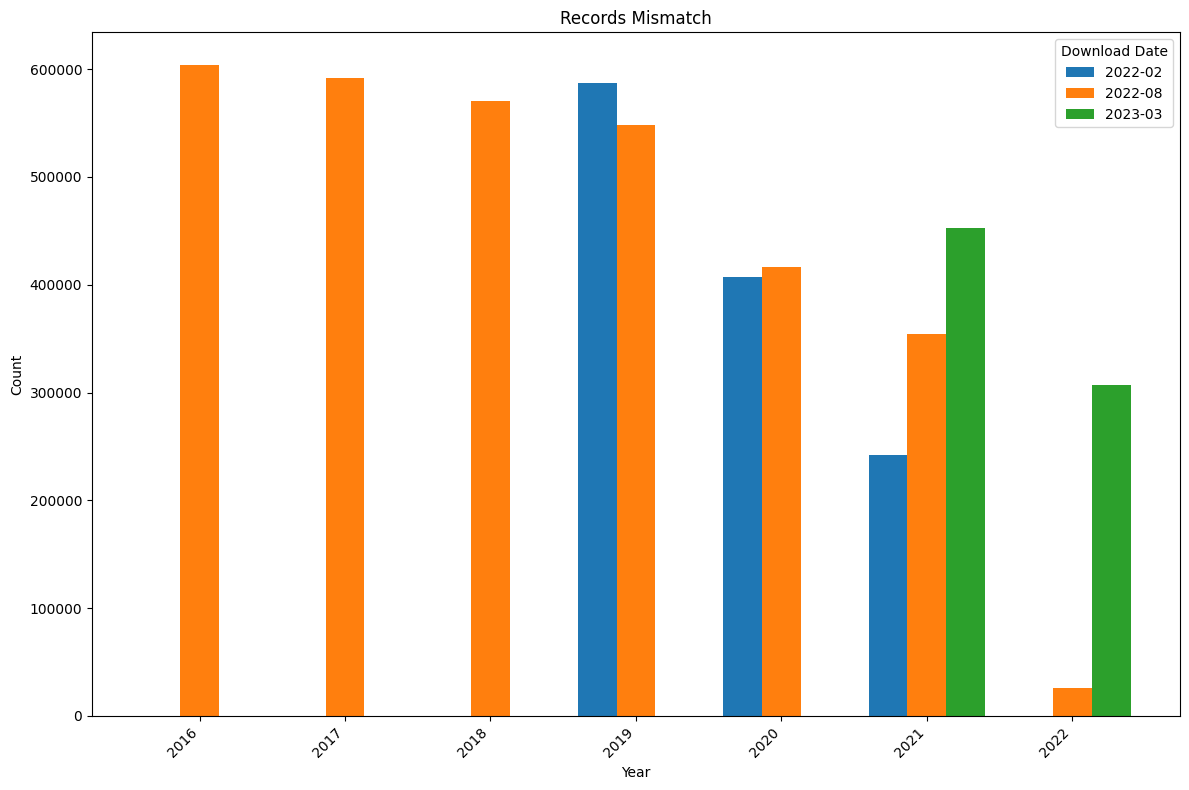

In [44]:
plot_stats(data)